# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import cv2
import glob as gb
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications import MobileNetV2

from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

2024-05-22 15:19:24.881044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 15:19:24.881162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 15:19:24.988015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Extracting the Compressed Datasets 

from zipfile import ZipFile 

train_folder  = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
           
with ZipFile(train_folder,'r') as zip :
    zip.extractall(path = '/kaggle/working/')
    print('The train_folder is extracted')

The train_folder is extracted


In [3]:
train_path, train_dirs, train_files = next(os.walk('/kaggle/working/train'))
print('Number of images in train is :',len(train_files))

Number of images in train is : 25000


In [4]:
train_files[0:5]

['dog.289.jpg', 'cat.3061.jpg', 'cat.1172.jpg', 'dog.5158.jpg', 'dog.1418.jpg']

In [5]:
# Check the balance of the training data

categories=[]
for img in train_files :
    category=img.split('.')[0]
    if category=='dog':
        categories.append('dog')
    else :
        categories.append('cat')
        
df=pd.DataFrame({'Image':train_files,'Category':categories})

df

Image Category
0        dog.289.jpg      dog
1       cat.3061.jpg      cat
2       cat.1172.jpg      cat
3       dog.5158.jpg      dog
4       dog.1418.jpg      dog
...              ...      ...
24995   cat.4448.jpg      cat
24996   cat.1129.jpg      cat
24997  cat.10013.jpg      cat
24998   cat.6887.jpg      cat
24999  dog.10285.jpg      dog

[25000 rows x 2 columns]

# Visualizations

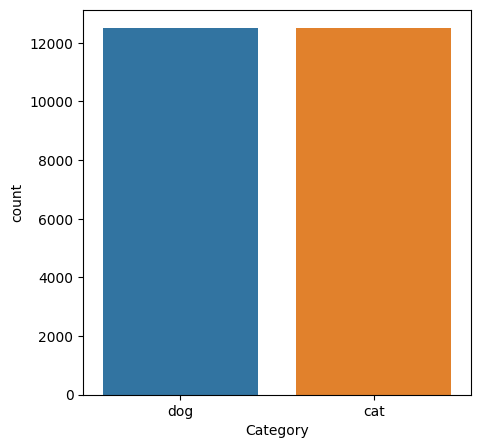

In [6]:
plt.figure(figsize=(5,5))
sns.countplot(data=df,x='Category');

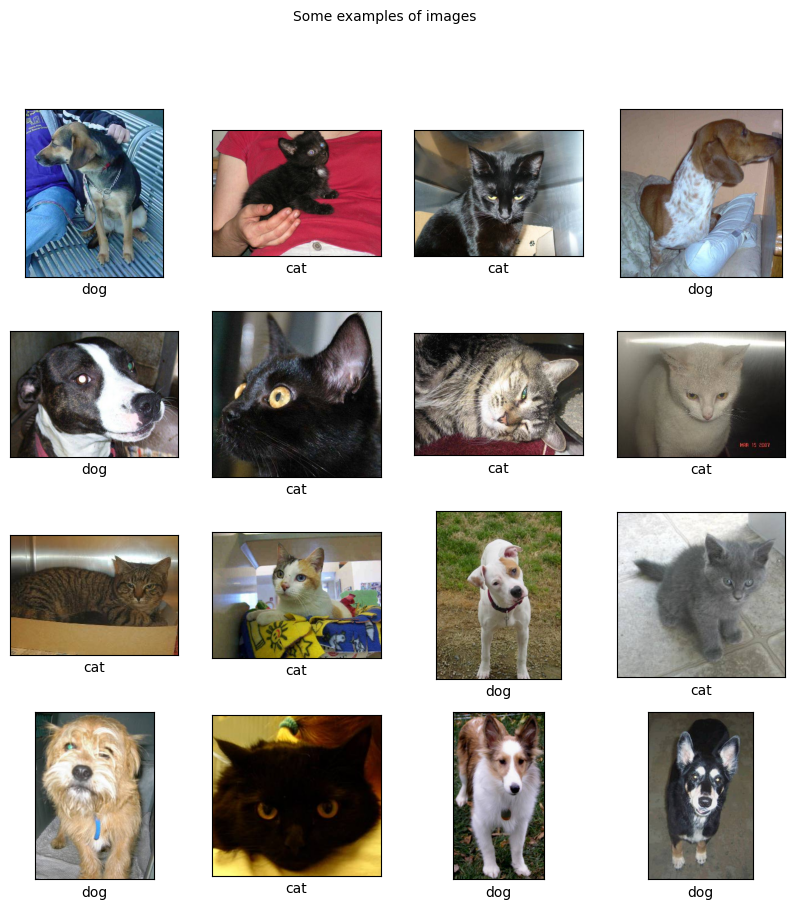

In [7]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of images", fontsize=10)
for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(plt.imread('/kaggle/working/train/'+train_files[i]))
        plt.xlabel(categories[i])
plt.show()

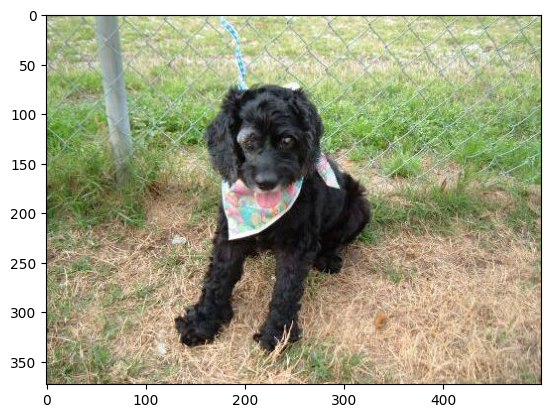

In [8]:
#plot random image from the training set
sample=np.random.choice(train_files)
plt.imshow(plt.imread('/kaggle/working/train/'+sample))


In [9]:
# Splitting the data 
train,validation =train_test_split(df,test_size=0.2,random_state=42)
train.head()

Image Category
23311  cat.11288.jpg      cat
23623   dog.7014.jpg      dog
1020   cat.10433.jpg      cat
12645   dog.3778.jpg      dog
1533    cat.9234.jpg      cat

In [10]:
# Rename the index of train and test
train = train.reset_index(drop=True)
validation  = validation.reset_index(drop=True)
train.head()

Image Category
0  cat.11288.jpg      cat
1   dog.7014.jpg      dog
2  cat.10433.jpg      cat
3   dog.3778.jpg      dog
4   cat.9234.jpg      cat

# Prepare Generator

In [11]:
# Data augmentation for training

train_datagen = ImageDataGenerator(
    
    rescale=1.0/255,                                     # Rescale pixel values to [0, 1]
    rotation_range=20,                                   # Random rotation within 20 degrees
    width_shift_range=0.2,                               # Random horizontal shift by 20% of image width
    height_shift_range=0.2,                              # Random vertical shift by 20% of image height
    horizontal_flip=True,                                # Random horizontal flipping
    fill_mode='nearest'                                  # Fill mode for new pixels after shifts/rotations
)


train_generator = train_datagen.flow_from_dataframe(
                                            
     train,                                              # dataframe
     directory="/kaggle/working/train",    
     x_col='Image',
     y_col='Category',
     target_size=(224, 224),                             # Resize images to this size
     batch_size=32,                                      # Number of images in each batch
     seed=42,                                            # Optional: Set a random seed for shuffling
     class_mode='categorical',                           # Mode for class labels (categorical for one-hot encoding)
) 

Found 20000 validated image filenames belonging to 2 classes.


In [12]:
# Data augmentation for testing

validation_datagen  = ImageDataGenerator( rescale = 1.0/255.)    # Rescale pixel values to [0, 1]

validation_generator = validation_datagen.flow_from_dataframe(
    
     validation,
     directory="/kaggle/working/train",
     x_col='Image',
     y_col='Category',
     target_size = (224, 224),
     batch_size=32,
     class_mode  = 'categorical',
     shuffle = False                      #shuffle=False to keep the order of image labels matching the generator & 
                                                                         #get good results in Confusion_Matrix  
)

Found 5000 validated image filenames belonging to 2 classes.


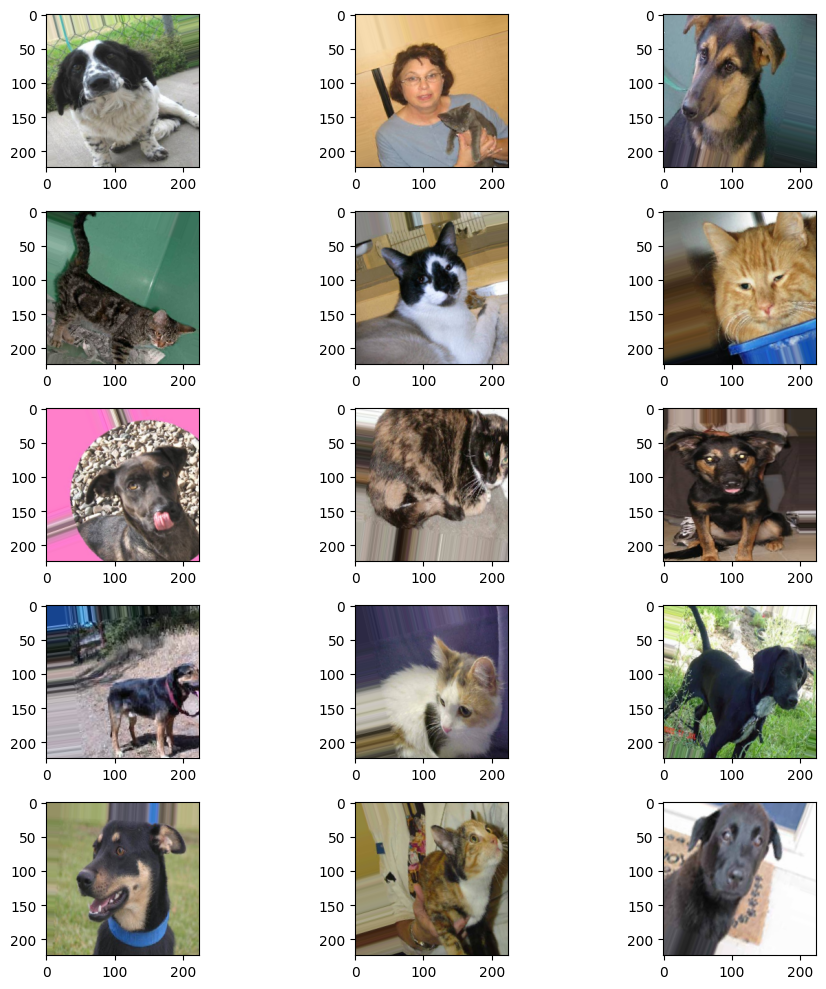

In [13]:
# show augmentation

plt.figure(figsize=(10, 10))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for img, label in train_generator:
        image = img[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Transfer Learning Model

In [14]:
MobileNetV2_model = MobileNetV2(
                                     input_shape=(224,224,3),
                                     weights='imagenet',
                                     include_top=False
                                     )
MobileNetV2_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model = tf.keras.models.Sequential([
    
    MobileNetV2_model,
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax'),
])


In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

In [18]:
batch_size = 64

history = model.fit(
                    train_generator,
                    steps_per_epoch  = train_generator.samples // batch_size,
                    validation_data  = validation_generator,
                    validation_steps = validation_generator.samples // batch_size,
                    callbacks=[early_stopping], verbose=1,
                    epochs = 20
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/312 ━━━━━━━━━━━━━━━━━━━━ 1:36:08 19s/step - accuracy: 0.7188 - loss: 0.8126

I0000 00:00:1716391218.052118      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716391218.086731      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9341 - loss: 0.2472

W0000 00:00:1716391337.673822      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 142s 398ms/step - accuracy: 0.9341 - loss: 0.2468 - val_accuracy: 0.9772 - val_loss: 0.0674
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9634 - loss: 0.1047 - val_accuracy: 0.9800 - val_loss: 0.0545
Epoch 3/20
  1/312 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9688 - loss: 0.1522

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9688 - loss: 0.1522 - val_accuracy: 0.8750 - val_loss: 0.1086
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 123s 385ms/step - accuracy: 0.9680 - loss: 0.0863 - val_accuracy: 0.9788 - val_loss: 0.0534
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9705 - loss: 0.0753 - val_accuracy: 0.9800 - val_loss: 0.0538
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 111us/step - accuracy: 0.9688 - loss: 0.0499 - val_accuracy: 1.0000 - val_loss: 0.0769
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 124s 389ms/step - accuracy: 0.9730 - loss: 0.0769 - val_accuracy: 0.9728 - val_loss: 0.0683
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 118s 378ms/step - accuracy: 0.9672 - loss: 0.0828 - val_accuracy: 0.9864 - val_loss: 0.0424
Epoch 9/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 101us/step - accuracy: 0.9688 - loss: 0.1171 - val_accuracy: 0.8750 - val_loss: 0.1884
Epoch 10/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 124s 387ms/step - accuracy: 0.9727 - loss: 0.0722 - v

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,429,256 (192.37 MB)

 Trainable params: 16,057,090 (61.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 32,114,182 (122.51 MB)

In [20]:
# Save the Model for future use
for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)
    

# Evaluation

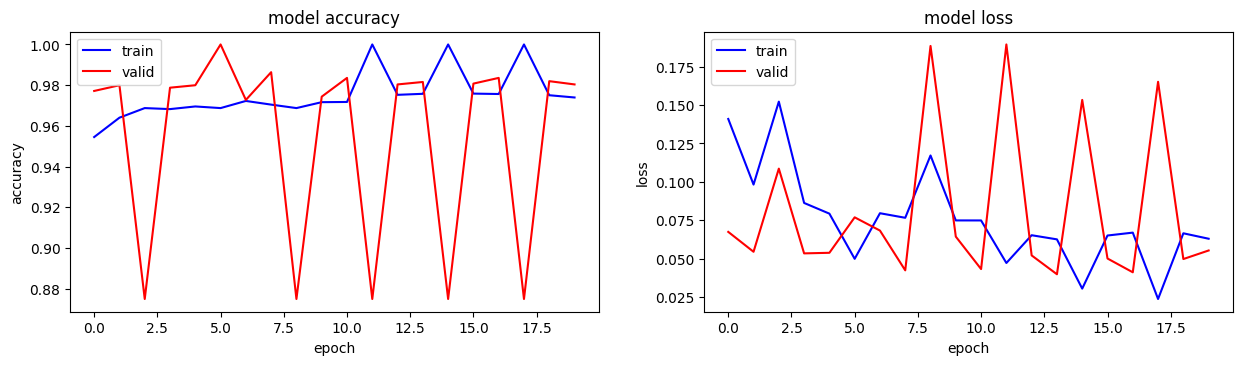

In [21]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'],'b')  
plt.plot(history.history['val_accuracy'],'r')  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'],'b')  
plt.plot(history.history['val_loss'],'r')  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [22]:
# Evaluate on validation dataset
score = model.evaluate(validation_generator ,verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05664316564798355
Test accuracy: 0.9789999723434448


In [23]:
# Make predictions on the validation data
predictions = model.predict(validation_generator)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)


# Get true labels from the validation_generator
true_labels = validation_generator.classes

labels =['Cat','Dog']

print(classification_report(true_labels,predicted_labels,target_names=labels))


  4/157 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step

W0000 00:00:1716392929.061425      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step
              precision    recall  f1-score   support

         Cat       0.99      0.97      0.98      2544
         Dog       0.97      0.99      0.98      2456

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



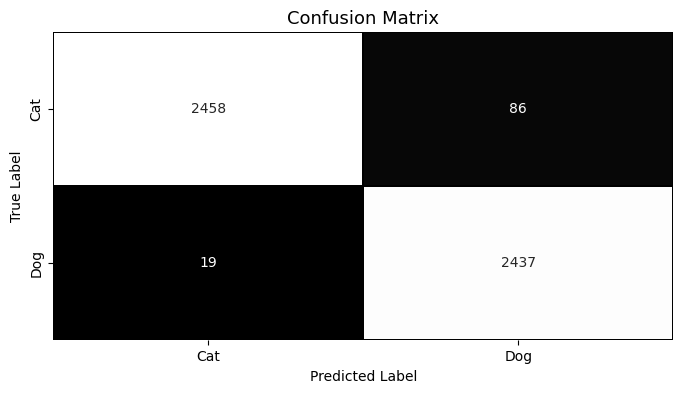

In [24]:
confusion_mtx = confusion_matrix(true_labels,predicted_labels) 

f,ax = plt.subplots(figsize = (8,4),dpi=100)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1,
            cmap = "gist_yarg_r", linecolor="black",
            fmt='.0f', ax=ax,cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


W0000 00:00:1716392947.446318      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


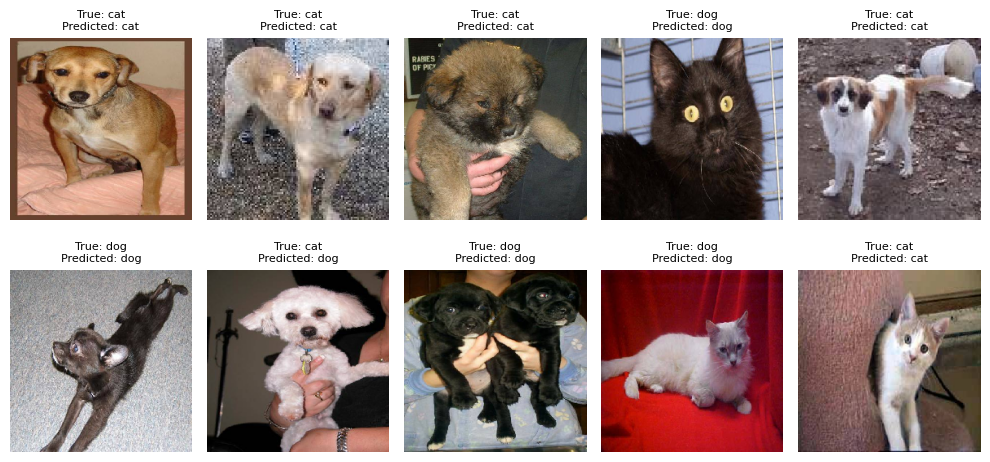

In [25]:
# Collect true labels and model predictions
true_labels = []
predicted_labels = []
class_names = validation_generator.class_indices.keys()    
class_names = list(class_names)
num_batches = len(validation_generator)                         # num_batches = 157  each batch is 32

for i in range(20):
    x_batch,y_batch = validation_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))              # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

# Plot true labels and predicted labels
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2,5, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

 # Predict Test Data

In [26]:
test_folder  = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'
           
with ZipFile(test_folder,'r') as zip :
    zip.extractall(path = "/kaggle/working/")
    print('The test_folder is extracted')
    
test_path,  test_dirs,  test_files  = next(os.walk('/kaggle/working/test'))
print('Number of images in test is :',len(test_files))

The test_folder is extracted
Number of images in test is : 12500


In [27]:
test_data = pd.DataFrame({"filename": test_files})
test_data['label'] = 'unknown'
test_data

filename    label
0       2747.jpg  unknown
1       9493.jpg  unknown
2       6780.jpg  unknown
3       3050.jpg  unknown
4       5792.jpg  unknown
...          ...      ...
12495   5351.jpg  unknown
12496   8930.jpg  unknown
12497   4631.jpg  unknown
12498  11093.jpg  unknown
12499   3611.jpg  unknown

[12500 rows x 2 columns]

In [28]:
# Create data genenerator for test data
test_generator =  validation_datagen.flow_from_dataframe(test_data, 
                                     "/kaggle/working/test", 
                                     x_col= "filename",
                                     y_col= 'label',
                                     target_size=(224,224),
                                     batch_size=32,
                                     shuffle=False)

Found 12500 validated image filenames belonging to 1 classes.


In [29]:
# Test Prediction
test_prediction = model.predict(test_generator,verbose = 0)

test_prediction_argmax = np.argmax(test_prediction, axis=1)

y_test_pred = test_prediction_argmax

test_data['label'] = y_test_pred

# mapping
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head(10)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1716392964.905470      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


filename label
0   2747.jpg   cat
1   9493.jpg   dog
2   6780.jpg   cat
3   3050.jpg   dog
4   5792.jpg   cat
5  12474.jpg   cat
6    363.jpg   dog
7   8237.jpg   cat
8  10237.jpg   cat
9  10398.jpg   cat

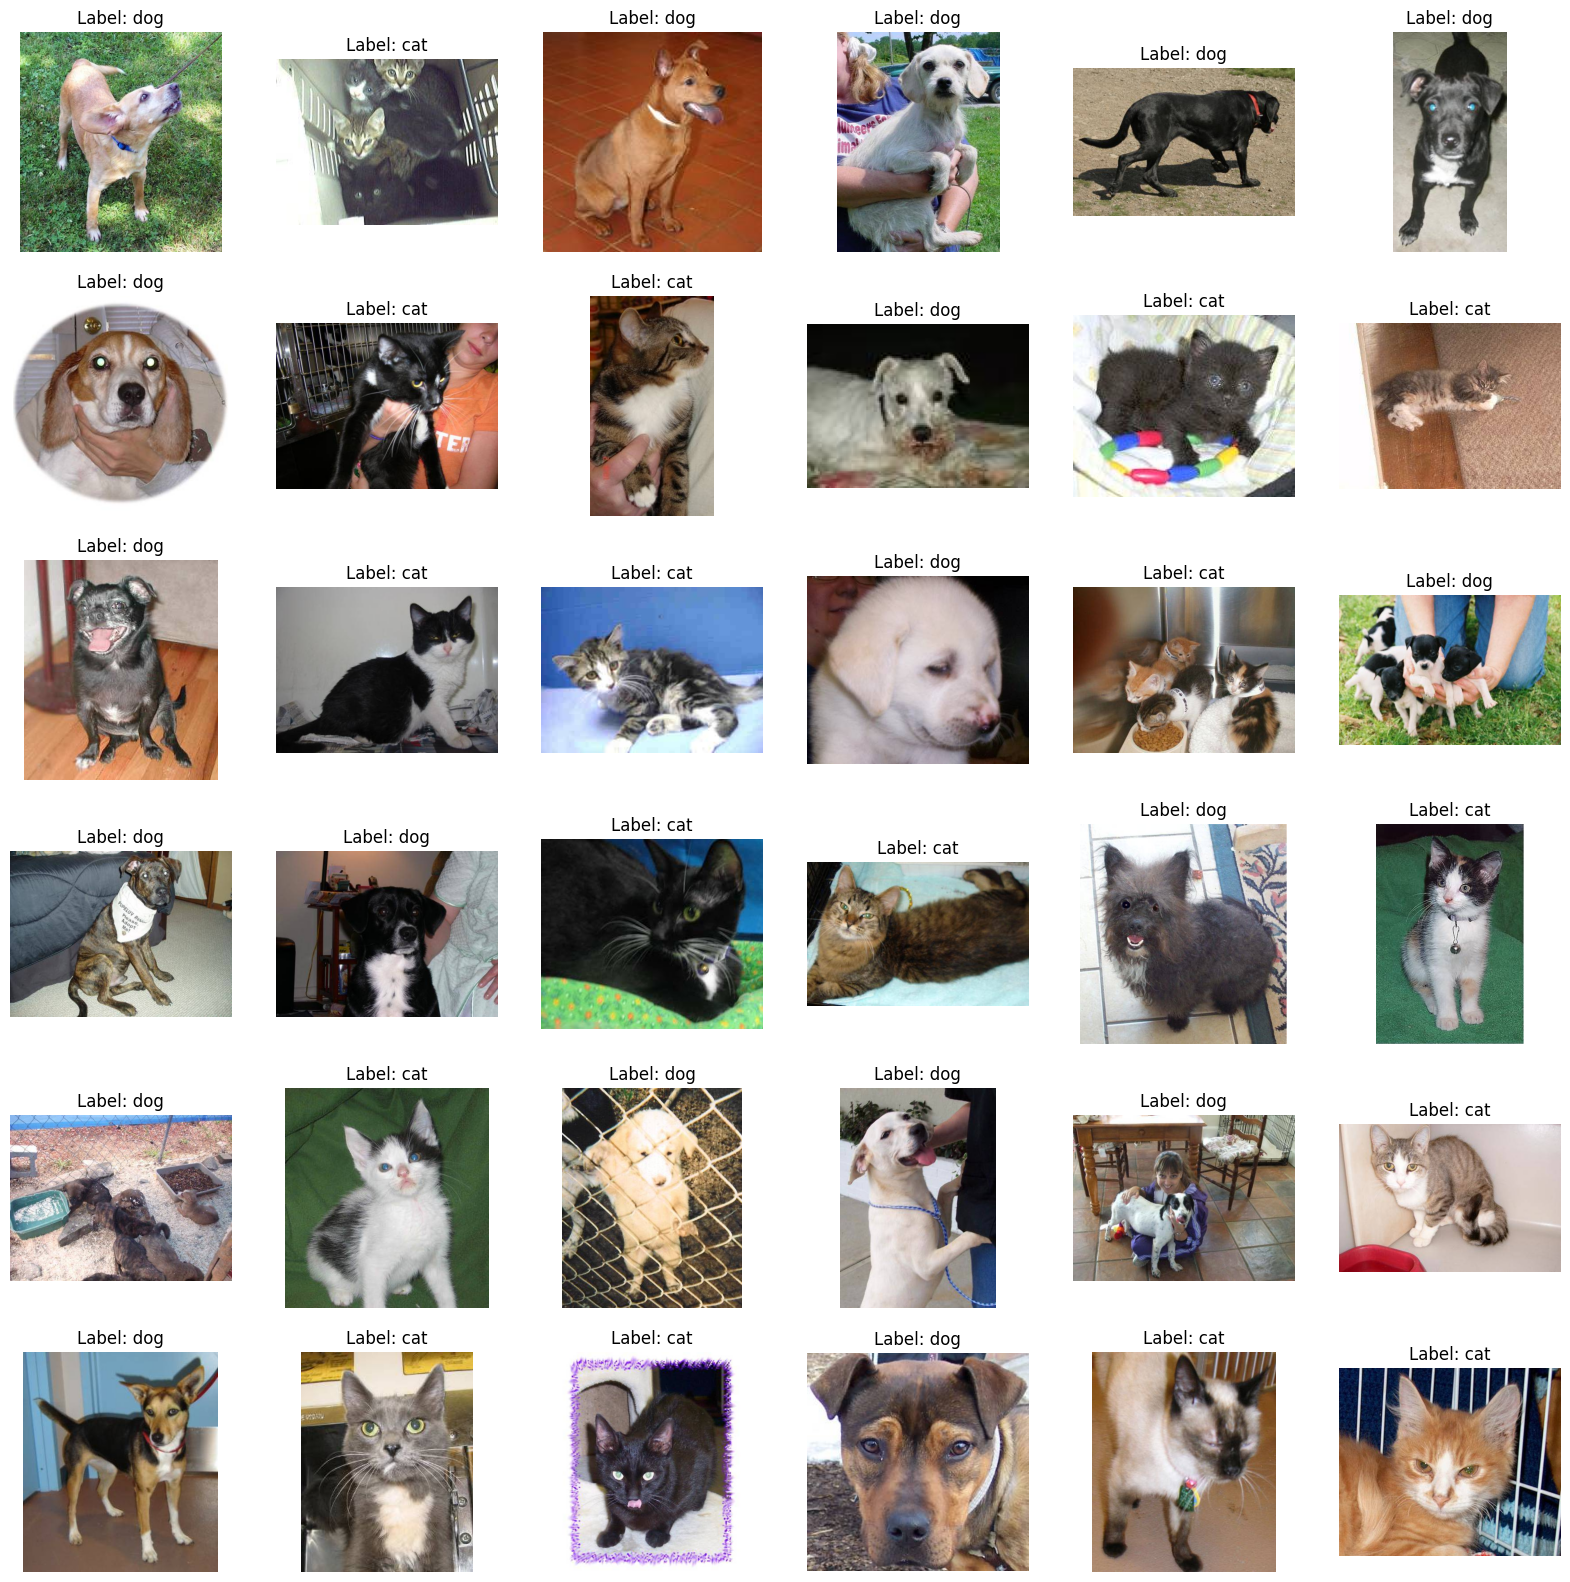

In [30]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(test_files),36))) : 
    plt.subplot(6,6,n+1)
    image_path = os.path.join(test_path, test_data.iloc[i]['filename'])
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title("Label: " + test_data.iloc[i]['label'])
    plt.axis('off')
plt.show()


# Submission

In [31]:
# csv file output for submission
submission = pd.read_csv('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv',index_col='id')

submission['label'] = y_test_pred

submission.to_csv('submission.csv',index=True)

In [32]:
submission

label
id          
1          0
2          1
3          0
4          1
5          0
...      ...
12496      1
12497      0
12498      1
12499      1
12500      0

[12500 rows x 1 columns]